In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('games-features.csv');

In [3]:
df.drop(columns=['RequiredAge', 'PCReqsHaveMin', 'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 
                 'MacReqsHaveMin', 'MacReqsHaveRec', 'Website', 'PCMinReqsText', 'PCRecReqsText', 
                 'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText', 'MacRecReqsText',
                'SupportEmail', 'SupportURL', 'AboutText', 'Background', 'ShortDescrip', 
                 'DetailedDescrip', 'DRMNotice', 'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews', 'DeveloperCount'],
        inplace = True
       );

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 52 columns):
QueryID                        13357 non-null int64
ResponseID                     13357 non-null int64
QueryName                      13356 non-null object
ResponseName                   13357 non-null object
ReleaseDate                    13357 non-null object
DemoCount                      13357 non-null int64
DLCCount                       13357 non-null int64
Metacritic                     13357 non-null int64
MovieCount                     13357 non-null int64
PackageCount                   13357 non-null int64
RecommendationCount            13357 non-null int64
PublisherCount                 13357 non-null int64
ScreenshotCount                13357 non-null int64
SteamSpyOwners                 13357 non-null int64
SteamSpyOwnersVariance         13357 non-null int64
SteamSpyPlayersEstimate        13357 non-null int64
SteamSpyPlayersVariance        13357 non-null int64
Achi

In [5]:
df['Relised'] = True

In [6]:
df['ReleaseDateStr'] = df['ReleaseDate']

In [7]:
def conert_str_to_date(df, key):
    years_ = ['2016', '2017', '2019',]
    soon_ = 'skoro|someday|20XX|coming|announced|soon|tba|tbc|tbd|early|-|breve'
    periods_ = {
        'q1|Q1': 'Feb',
        'q2|q 2 ': 'May',
        'q3': 'Aug',
        'q4': 'Nov',
        'mid': 'Jul',
        'fall|autumn|utumn': 'Oct',
        'end': 'Dec',
        'spring': 'Apr',
        'winter': 'Dec',
        'summer': 'Jul',
        'january': 'Jan', 
        'february': 'Feb',
        'march': 'Mar',
        'april': 'Apr',
        #'may': 'May',
        'june': 'Jun',
        'july': 'Jul',
        'august': 'Aug',
        'september': 'Sep',
        'october': 'Oct',
        'november': 'Nov',
        'december': 'Dec'
    }
    
    for period_, month_ in periods_.items():
        for year_ in years_:
            df.loc[(df[key].str.contains(period_, case=False)) & (df[key].str.contains(year_)), [key, 'Relised']] = month_ + ' ' + year_, False
        df.loc[(df[key].str.contains(period_, case=False)), [key, 'Relised']] = month_ + ' 2017', False
    for year_ in years_:
        df.loc[((df[key].str.len() != 8) & (df[key].str.len() != 10) & (df[key].str.len() != 11)) & (df[key].str.contains(year_)), [key, 'Relised']] = year_, False
    df.loc[df[key].str.contains(soon_, case=False), [key, 'Relised']] = '2017', False
    df.loc[(df[key].str.len() != 4) & (df[key].str.len() != 8) & (df[key].str.len() != 10) & (df[key].str.len() != 11), [key]] = '2017'

In [8]:
conert_str_to_date(df, 'ReleaseDate')

In [9]:
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

In [10]:
df["ReleaseDate"] = df["ReleaseDate"].astype("datetime64")

In [11]:
df["ReleaseYear"] = df["ReleaseDate"].dt.year
df["ReleaseMonth"] = df["ReleaseDate"].dt.month
df["ReleaseDay"] = df["ReleaseDate"].dt.day

In [12]:
df.loc[(df['Relised'] == False)]['QueryID'].count()

601

In [13]:
df.loc[(df['GenreIsNonGame'] == True)]['QueryID'].count()

319

### Исключить из списка не игры, а так же не вышедшие или в раннем доступе, по стостянию на 2016 год

In [14]:
df['QueryID'].count()

13357

In [15]:
df = df.loc[
    (df['Relised'] == True) & 
    (df['GenreIsNonGame'] == False) & 
    (
        (df['GenreIsEarlyAccess'] == False) | 
        (
            (df['GenreIsEarlyAccess'] == True) & (df['SteamSpyOwners'] > 0)
        )
    )]

In [16]:
df['QueryID'].count()

12099

### Удалить дубликаты

In [17]:
df.drop_duplicates(subset='ResponseID', keep="first", inplace=True);

In [18]:
df['QueryID'].count()

11951

## Рассчет потенциальной выручки (без учета скидок и распродаж и региональных цен) по состоянию на 2016 год

In [19]:
df['PotentialRevenue'] = df['PriceFinal'] * df['SteamSpyOwners']

### Рост кол-ва игр на Steam по состоянию на 2016 год

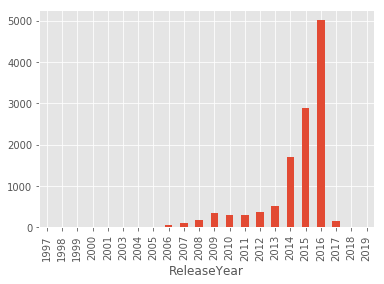

In [20]:
df.groupby(df["ReleaseYear"])['QueryID'].count().plot(kind="bar")

### Периодичность по месяцам

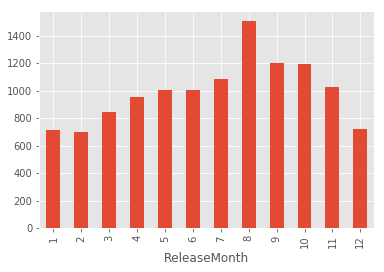

In [21]:
df.groupby(df["ReleaseMonth"])['QueryID'].count().plot(kind="bar")

In [22]:
genres_list = [
    'GenreIsIndie',
    'GenreIsAction',
    'GenreIsAdventure',
    'GenreIsCasual',
    'GenreIsStrategy',
    'GenreIsRPG',
    'GenreIsSimulation',
    #'GenreIsEarlyAccess'
    'GenreIsFreeToPlay',
    'GenreIsSports',
    'GenreIsRacing',
    'GenreIsMassivelyMultiplayer',
]
genres_dicts = []
for g in genres_list: 
    genres_dicts.append({
        'genre': g,
        'count': df.loc[(df[g] == True), 'QueryName'].count(),
        'metacritic_mean': df.loc[(df[g] == True) & (df['Metacritic'] > 0), 'Metacritic'].mean(),
        'metacritic_std': df.loc[(df[g] == True) & (df['Metacritic'] > 0), 'Metacritic'].std(),
        'owners_sum': df.loc[(df[g] == True), 'SteamSpyOwners'].sum(),
        'owners_mean': df.loc[(df[g] == True), 'SteamSpyOwners'].mean(),
        'owners_std': df.loc[(df[g] == True), 'SteamSpyOwners'].std(),
        'players_sum': df.loc[(df[g] == True), 'SteamSpyPlayersEstimate'].sum(),
        'players_mean': df.loc[(df[g] == True), 'SteamSpyPlayersEstimate'].mean(),
        'players_std': df.loc[(df[g] == True), 'SteamSpyPlayersEstimate'].std(),
        'price_s_mean': df.loc[(df[g] == True), 'PriceInitial'].mean(),
        'price_s_std': df.loc[(df[g] == True), 'PriceInitial'].std(),
        'price_f_mean': df.loc[(df[g] == True), 'PriceFinal'].mean(),
        'price_f_std': df.loc[(df[g] == True), 'PriceFinal'].std(),
        'revenue_f_sum': df.loc[(df[g] == True), 'PotentialRevenue'].sum(),
        'revenue_f_mean': df.loc[(df[g] == True), 'PotentialRevenue'].mean(),
        'revenue_f_std': df.loc[(df[g] == True), 'PotentialRevenue'].std()
    })
    
genres = pd.DataFrame(genres_dicts)

### Жанры по наибольшей потенциальной выручке

In [23]:
genres.sort_values(by='revenue_f_mean', ascending=False)[['genre', 'count', 'revenue_f_mean', 'revenue_f_std', 'revenue_f_sum']]

,genre,count,revenue_f_mean,revenue_f_std,revenue_f_sum
1,GenreIsAction,5033,2.958240e+06,1.491633e+07,1.488882e+10
5,GenreIsRPG,1911,2.608651e+06,1.220565e+07,4.985132e+09
4,GenreIsStrategy,2410,2.037599e+06,9.809189e+06,4.910613e+09
10,GenreIsMassivelyMultiplayer,349,1.806597e+06,1.166296e+07,6.305024e+08
9,GenreIsRacing,436,1.740564e+06,7.718512e+06,7.606265e+08
2,GenreIsAdventure,3929,1.654237e+06,9.388153e+06,6.499497e+09
6,GenreIsSimulation,1911,1.592237e+06,7.637649e+06,3.042766e+09
8,GenreIsSports,481,1.531169e+06,7.567264e+06,7.364922e+08
0,GenreIsIndie,7004,8.949526e+05,5.170600e+06,6.268248e+09
3,GenreIsCasual,3306,3.280734e+05,1.827093e+06,1.084611e+09


### Жанры по наибольшему числу игроков

In [24]:
genres.sort_values(by='players_mean', ascending=False)[['genre', 'count', 'players_mean', 'players_std', 'players_sum']]

,genre,count,players_mean,players_std,players_sum
7,GenreIsFreeToPlay,629,639852.717011,4.095698e+06,402467359
10,GenreIsMassivelyMultiplayer,349,400716.186246,1.020288e+06,139849949
1,GenreIsAction,5033,187803.636598,1.581736e+06,945215703
5,GenreIsRPG,1911,154544.056515,5.840688e+05,295333692
4,GenreIsStrategy,2410,136424.911203,1.876841e+06,328784036
6,GenreIsSimulation,1911,100527.751439,4.669426e+05,192108533
2,GenreIsAdventure,3929,89614.241283,5.019605e+05,352094354
8,GenreIsSports,481,79938.598753,3.030481e+05,38450466
9,GenreIsRacing,436,75258.816934,2.738235e+05,32888103
0,GenreIsIndie,7004,68561.082810,4.211146e+05,480201824


### Жанры по наибольшему числу покупателей (владельцев игр)

In [25]:
genres.sort_values(by='owners_mean', ascending=False)[['genre', 'count', 'owners_mean', 'owners_std', 'owners_sum']]

,genre,count,owners_mean,owners_std,owners_sum
7,GenreIsFreeToPlay,629,910959.866455,4.268570e+06,572993756
10,GenreIsMassivelyMultiplayer,349,653609.687679,1.525681e+06,228109781
1,GenreIsAction,5033,282749.455792,1.741520e+06,1423078011
5,GenreIsRPG,1911,235888.715332,7.525453e+05,450783335
4,GenreIsStrategy,2410,191187.864730,1.897197e+06,460762754
6,GenreIsSimulation,1911,138061.141811,5.935432e+05,263834842
2,GenreIsAdventure,3929,136059.938407,6.396463e+05,534579498
8,GenreIsSports,481,122515.274428,4.456559e+05,58929847
9,GenreIsRacing,436,114601.189931,3.738188e+05,50080720
0,GenreIsIndie,7004,103267.833238,5.382770e+05,723287904


### Жанры по наибольшей оценке критиков

In [26]:
genres.sort_values(by='metacritic_mean', ascending=False)[['genre', 'count', 'metacritic_mean', 'metacritic_std']]

,genre,count,metacritic_mean,metacritic_std
8,GenreIsSports,481,74.596774,9.580478
10,GenreIsMassivelyMultiplayer,349,74.040000,8.836289
5,GenreIsRPG,1911,73.319202,10.464600
9,GenreIsRacing,436,72.747253,10.642257
7,GenreIsFreeToPlay,629,72.265625,11.187070
4,GenreIsStrategy,2410,71.869048,10.665018
3,GenreIsCasual,3306,71.315789,8.502590
1,GenreIsAction,5033,71.259535,12.271926
2,GenreIsAdventure,3929,71.177748,10.634217
0,GenreIsIndie,7004,70.820359,10.502065


In [27]:
genres_similar = []
for g in genres_list:
    sim = {
        'name': g,
    }
    for j in genres_list:
        mean = df.loc[(df[j] == True) & (df[g] == True) & (df['Relised'] == True) & (df['PotentialRevenue'] > 0), 'PotentialRevenue'].mean()
        sim[j] = mean
    genres_similar.append(sim) 
    
similar = pd.DataFrame(genres_similar)  
genres = pd.DataFrame(genres_dicts)


In [28]:
similar.sort_values(by='GenreIsCasual', ascending=False)

,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsFreeToPlay,GenreIsIndie,GenreIsMassivelyMultiplayer,GenreIsRPG,GenreIsRacing,GenreIsSimulation,GenreIsSports,GenreIsStrategy,name
5,4.337395e+06,1.943493e+06,706538.886504,1.612924e+04,1.499393e+06,6.913291e+06,3.271084e+06,3.456116e+05,1.666545e+06,3.267270e+05,1.644238e+06,GenreIsRPG
10,7.832267e+06,8.614841e+06,612288.667619,1.612924e+04,5.191648e+06,5.579667e+06,6.913291e+06,1.416896e+06,1.950237e+06,1.254567e+05,1.852028e+06,GenreIsMassivelyMultiplayer
4,2.139675e+06,1.201251e+06,576195.849608,4.116390e+05,1.270482e+06,1.852028e+06,1.644238e+06,1.171903e+06,2.298365e+06,8.690119e+05,2.485128e+06,GenreIsStrategy
9,1.515536e+06,1.194800e+06,540317.457353,NaN,1.184661e+06,1.416896e+06,3.456116e+05,2.066920e+06,2.380472e+06,3.892544e+06,1.171903e+06,GenreIsRacing
6,1.792316e+06,1.625420e+06,534781.651092,6.154550e+05,1.637894e+06,1.950237e+06,1.666545e+06,2.380472e+06,1.963075e+06,1.977002e+06,2.298365e+06,GenreIsSimulation
2,3.414725e+06,2.040018e+06,515498.127484,1.612924e+04,1.201525e+06,8.614841e+06,1.943493e+06,1.194800e+06,1.625420e+06,2.950055e+05,1.201251e+06,GenreIsAdventure
1,3.648327e+06,3.414725e+06,501995.767601,1.209399e+06,1.254607e+06,7.832267e+06,4.337395e+06,1.515536e+06,1.792316e+06,1.719828e+06,2.139675e+06,GenreIsAction
8,1.719828e+06,2.950055e+05,483804.430825,NaN,1.195081e+06,1.254567e+05,3.267270e+05,3.892544e+06,1.977002e+06,2.074626e+06,8.690119e+05,GenreIsSports
0,1.254607e+06,1.201525e+06,461525.014325,3.127616e+05,1.105901e+06,5.191648e+06,1.499393e+06,1.184661e+06,1.637894e+06,1.195081e+06,1.270482e+06,GenreIsIndie
3,5.019958e+05,5.154981e+05,427348.533944,2.151065e+04,4.615250e+05,6.122887e+05,7.065389e+05,5.403175e+05,5.347817e+05,4.838044e+05,5.761958e+05,GenreIsCasual


## Сочетания жанров с наибольшей потенциальной средней выручкой

In [29]:
columns = ['ResponseID', 'ResponseName', 'ReleaseDate', 'Metacritic', 'SteamSpyOwners', 'SteamSpyPlayersEstimate', 'PriceCurrency', 'PriceInitial', 'PriceFinal', 'PotentialRevenue']

### Многопользовательский мультиплеер с Адвенчурой

In [30]:
df.loc[(df['GenreIsMassivelyMultiplayer'] == True) & (df['GenreIsAdventure'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
8700,433850,H1Z1: King of the Kill,2016-02-17,0,3186504,1899133,USD,19.99,19.99,6.369821e+07
3720,295110,H1Z1 : Just Survive,2015-01-15,0,2631417,2577612,USD,19.99,19.99,5.260203e+07
5995,359320,Elite Dangerous,2015-04-02,80,905177,846530,USD,29.99,29.99,2.714626e+07
1854,215280,The Secret World,2012-08-08,74,418961,347400,USD,29.99,29.99,1.256464e+07
3859,299740,Miscreated,2014-10-30,0,441200,394210,USD,19.99,19.99,8.819588e+06
12682,454650,DRAGON BALL XENOVERSE 2,2016-10-27,0,132181,128594,USD,49.99,49.99,6.607728e+06
3019,269210,Hero Siege,2014-01-29,0,907688,769230,USD,5.99,5.99,5.437051e+06
4181,311310,Naval Action,2016-01-21,0,87343,85729,USD,39.99,39.99,3.492847e+06


### Многопользовательский мультиплеер Экшен

In [31]:
df.loc[(df['GenreIsMassivelyMultiplayer'] == True) & (df['GenreIsAction'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
1950,221100,DayZ,2013-12-16,0,3610845,3578742,USD,34.99,34.99,1.263435e+08
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
8700,433850,H1Z1: King of the Kill,2016-02-17,0,3186504,1899133,USD,19.99,19.99,6.369821e+07
3720,295110,H1Z1 : Just Survive,2015-01-15,0,2631417,2577612,USD,19.99,19.99,5.260203e+07
5995,359320,Elite Dangerous,2015-04-02,80,905177,846530,USD,29.99,29.99,2.714626e+07
2046,226700,Infestation: Survivor Stories Classic,2012-12-17,0,1089190,1037179,USD,9.99,9.99,1.088101e+07
2315,241560,The Crew(tm),2014-12-01,71,333052,325161,USD,29.99,29.99,9.988229e+06
3859,299740,Miscreated,2014-10-30,0,441200,394210,USD,19.99,19.99,8.819588e+06
12682,454650,DRAGON BALL XENOVERSE 2,2016-10-27,0,132181,128594,USD,49.99,49.99,6.607728e+06


### Многопользовательский мультиплеер с РПГ

In [32]:
df.loc[(df['GenreIsMassivelyMultiplayer'] == True) & (df['GenreIsRPG'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
4061,306130,The Elder Scrolls(r) Online: Tamriel Unlimited...,2015-03-17,0,929210,848324,USD,29.99,29.99,2.786701e+07
5995,359320,Elite Dangerous,2015-04-02,80,905177,846530,USD,29.99,29.99,2.714626e+07
1854,215280,The Secret World,2012-08-08,74,418961,347400,USD,29.99,29.99,1.256464e+07
267,8500,EVE Online,2010-12-15,88,592571,484961,USD,19.99,19.99,1.184549e+07
2046,226700,Infestation: Survivor Stories Classic,2012-12-17,0,1089190,1037179,USD,9.99,9.99,1.088101e+07
1005,39210,FINAL FANTASY(r) XIV: A Realm Reborn(tm),2014-02-18,83,499309,435461,USD,19.99,19.99,9.981187e+06
3859,299740,Miscreated,2014-10-30,0,441200,394210,USD,19.99,19.99,8.819588e+06
3019,269210,Hero Siege,2014-01-29,0,907688,769230,USD,5.99,5.99,5.437051e+06


### Многопользовательский мультиплеер Инди

In [33]:
df.loc[(df['GenreIsMassivelyMultiplayer'] == True) & (df['GenreIsIndie'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
1950,221100,DayZ,2013-12-16,0,3610845,3578742,USD,34.99,34.99,1.263435e+08
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
2046,226700,Infestation: Survivor Stories Classic,2012-12-17,0,1089190,1037179,USD,9.99,9.99,1.088101e+07
3859,299740,Miscreated,2014-10-30,0,441200,394210,USD,19.99,19.99,8.819588e+06
3019,269210,Hero Siege,2014-01-29,0,907688,769230,USD,5.99,5.99,5.437051e+06
4686,326460,ShellShock Live,2015-03-11,0,554190,537690,USD,6.99,6.99,3.873788e+06
2444,247730,Nether: Resurrected,2014-06-05,57,717398,637946,USD,4.99,4.99,3.579816e+06
4181,311310,Naval Action,2016-01-21,0,87343,85729,USD,39.99,39.99,3.492847e+06
6099,361800,Tree of Life,2015-05-27,0,81066,78734,USD,19.99,19.99,1.620509e+06


### Экшен Адвенчура

In [34]:
df.loc[(df['GenreIsAction'] == True) & (df['GenreIsAdventure'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
3088,271590,Grand Theft Auto V,2015-04-13,96,5886074,5756584,USD,59.99,59.99,3.531056e+08
24,620,Portal 2,2011-04-18,95,8741499,7282849,USD,19.99,19.99,1.747426e+08
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
1594,203160,Tomb Raider,2013-03-04,86,4453968,3663933,USD,19.99,19.99,8.903482e+07
367,12210,Grand Theft Auto IV,2008-12-02,90,4174362,3520274,USD,19.99,19.99,8.344550e+07
4176,311210,Call of Duty(r): Black Ops III,2015-11-05,0,1378660,1309969,USD,59.99,59.99,8.270581e+07
1477,105600,Terraria,2011-05-16,83,8165607,7764044,USD,9.99,9.99,8.157441e+07
2324,241930,Middle-earth(tm): Shadow of Mordor(tm),2014-09-30,0,2593574,2274870,USD,29.99,29.99,7.778128e+07
7273,391220,Rise of the Tomb Raider(tm),2016-01-28,86,1186398,1077353,USD,59.99,59.99,7.117202e+07


### Экшен РПГ

In [35]:
df.loc[(df['GenreIsAction'] == True) & (df['GenreIsRPG'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
1904,218620,PAYDAY 2,2013-08-13,79,7278903,6745338,USD,19.99,19.99,1.455053e+08
1198,49520,Borderlands 2,2012-09-17,89,6969346,6263964,USD,19.99,19.99,1.393172e+08
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
2285,239140,Dying Light: The Following - Enhanced Edition,2015-01-26,87,1614684,1547966,USD,59.99,59.99,9.686489e+07
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
1477,105600,Terraria,2011-05-16,83,8165607,7764044,USD,9.99,9.99,8.157441e+07
11754,409710,BioShock(tm) Remastered,2016-09-15,0,3635775,460211,USD,19.99,19.99,7.267914e+07
232,7670,BioShock(tm),2007-08-21,96,3635595,2429649,USD,19.99,19.99,7.267554e+07
2802,261640,Borderlands: The Pre-Sequel,2014-10-13,75,1708843,1446992,USD,39.99,39.99,6.833663e+07
1550,200710,Torchlight II,2012-09-20,88,3352402,3051095,USD,19.99,19.99,6.701452e+07


### РПГ Адвенчура

In [36]:
df.loc[(df['GenreIsAdventure'] == True) & (df['GenreIsRPG'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
1477,105600,Terraria,2011-05-16,83,8165607,7764044,USD,9.99,9.99,8.157441e+07
1550,200710,Torchlight II,2012-09-20,88,3352402,3051095,USD,19.99,19.99,6.701452e+07
1820,213670,South Park(tm): The Stick of Truth(tm),2014-03-03,0,1963340,1756550,USD,29.99,29.99,5.888057e+07
6279,365590,Tom Clancys The Division(tm),2016-03-07,0,931362,912710,USD,59.99,59.99,5.587241e+07
12692,462780,Darksiders Warmastered Edition,2016-11-29,0,2548378,109583,USD,19.99,19.99,5.094208e+07
1618,204360,Castle Crashers(r),2012-09-26,0,3280304,2875153,USD,14.99,14.99,4.917176e+07
6602,373420,Divinity: Original Sin - Enhanced Edition,2015-10-27,94,1206305,630234,USD,39.99,39.99,4.824014e+07
2540,251570,7 Days to Die,2013-12-13,0,1850170,1768925,USD,24.99,24.99,4.623575e+07


### Стратегический симулятор

In [37]:
df.loc[(df['GenreIsStrategy'] == True) & (df['GenreIsSimulation'] == True), columns].sort_values(by='PotentialRevenue', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
1484,107410,Arma 3,2013-09-12,74,2785120,2728087,USD,39.99,39.99,1.113769e+08
2663,255710,Cities: Skylines,2015-03-10,85,2968056,2829957,USD,29.99,29.99,8.901200e+07
784,33930,Arma 2: Operation Arrowhead,2010-06-29,73,4131318,3661780,USD,19.99,19.99,8.258505e+07
1476,105450,Age of Empires(r) III: Complete Collection,2012-01-05,81,1876355,1533260,USD,39.99,39.99,7.503544e+07
2164,233450,Prison Architect,2015-10-06,83,2120809,1924242,USD,29.99,29.99,6.360306e+07
2386,244850,Space Engineers,2013-10-23,0,2100542,1883350,USD,24.99,24.99,5.249254e+07
2343,242920,Banished,2014-02-18,0,1597825,1473177,USD,19.99,19.99,3.194052e+07
2968,266840,Age of Mythology: Extended Edition,2014-05-08,66,965977,825367,USD,29.99,29.99,2.896965e+07
5995,359320,Elite Dangerous,2015-04-02,80,905177,846530,USD,29.99,29.99,2.714626e+07
1806,212680,FTL: Faster Than Light,2012-09-14,84,2601286,2299082,USD,9.99,9.99,2.598685e+07


## Наиболее играемые сочетания жанров в среднем

 ### Экшен стратегии

In [38]:
df.loc[(df['GenreIsStrategy'] == True) & (df['GenreIsAction'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
23,570,Dota 2,2013-07-09,90,90687580,90687580,,0.00,0.00,0.000000e+00
784,33930,Arma 2: Operation Arrowhead,2010-06-29,73,4131318,3661780,USD,19.99,19.99,8.258505e+07
1484,107410,Arma 3,2013-09-12,74,2785120,2728087,USD,39.99,39.99,1.113769e+08
1978,222880,Insurgency,2014-01-22,74,3102568,2548199,USD,9.99,9.99,3.099465e+07
2222,236110,Dungeon Defenders II,2014-12-05,0,2546405,1911149,,0.00,0.00,0.000000e+00
5165,339610,Freestyle2: Street Basketball,2015-04-01,0,4012230,1885682,,0.00,0.00,0.000000e+00
2386,244850,Space Engineers,2013-10-23,0,2100542,1883350,USD,24.99,24.99,5.249254e+07
2465,248570,Toribash,2014-05-16,0,2497802,1810175,,0.00,0.00,0.000000e+00
1572,201790,Orcs Must Die! 2,2012-11-22,83,2295854,1731441,USD,24.99,24.99,5.737339e+07
1314,65800,Dungeon Defenders,2011-10-18,81,1988987,1651630,USD,14.99,14.99,2.981492e+07


### Экшен РПГ

In [39]:
df.loc[(df['GenreIsRPG'] == True) & (df['GenreIsAction'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
3909,301520,Robocraft,2014-07-08,0,11319470,8020334,,0.00,0.00,0.000000e+00
1477,105600,Terraria,2011-05-16,83,8165607,7764044,USD,9.99,9.99,8.157441e+07
1904,218620,PAYDAY 2,2013-08-13,79,7278903,6745338,USD,19.99,19.99,1.455053e+08
1198,49520,Borderlands 2,2012-09-17,89,6969346,6263964,USD,19.99,19.99,1.393172e+08
4006,304050,Trove,2015-07-09,0,7174342,5862400,,0.00,0.00,0.000000e+00
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
585,22380,Fallout: New Vegas,2010-10-19,84,4637980,4076078,USD,9.99,9.99,4.633342e+07
2280,238960,Path of Exile,2013-10-23,86,6170343,4071056,,0.00,0.00,0.000000e+00
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
1079,42910,Magicka,2011-01-25,74,3643666,3083199,USD,9.99,9.99,3.640022e+07


### Эдвенчура с массовым мультиплеером

In [40]:
df.loc[(df['GenreIsMassivelyMultiplayer'] == True) & (df['GenreIsAdventure'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
4006,304050,Trove,2015-07-09,0,7174342,5862400,,0.00,0.00,0.000000e+00
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
2280,238960,Path of Exile,2013-10-23,86,6170343,4071056,,0.00,0.00,0.000000e+00
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
1499,109600,Neverwinter,2013-12-05,74,4486609,2773641,,0.00,0.00,0.000000e+00
3720,295110,H1Z1 : Just Survive,2015-01-15,0,2631417,2577612,USD,19.99,19.99,5.260203e+07
611,24200,DC Universe(tm) Online,2011-11-02,72,2414763,2414763,,0.00,0.00,0.000000e+00
4594,323370,TERA,2015-05-05,77,3773336,2119015,,0.00,0.00,0.000000e+00
3282,280790,Creativerse,2014-08-12,0,2251196,1924062,,0.00,0.00,0.000000e+00
8700,433850,H1Z1: King of the Kill,2016-02-17,0,3186504,1899133,USD,19.99,19.99,6.369821e+07


### Экшен с массовым мультиплеером

In [41]:
df.loc[(df['GenreIsMassivelyMultiplayer'] == True) & (df['GenreIsAction'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
2081,227940,Heroes & Generals,2014-07-11,0,12908686,8764456,,0.00,0.00,0.000000e+00
3909,301520,Robocraft,2014-07-08,0,11319470,8020334,,0.00,0.00,0.000000e+00
4006,304050,Trove,2015-07-09,0,7174342,5862400,,0.00,0.00,0.000000e+00
2576,252490,Rust,2013-12-11,0,4684791,4485892,USD,19.99,19.99,9.364897e+07
1899,218230,PlanetSide 2,2012-11-20,84,7027275,4370032,,0.00,0.00,0.000000e+00
3114,273110,Counter-Strike Nexon: Zombies,2014-10-07,0,6954639,4315868,,0.00,0.00,0.000000e+00
2280,238960,Path of Exile,2013-10-23,86,6170343,4071056,,0.00,0.00,0.000000e+00
5451,346110,ARK: Survival Evolved,2015-06-02,0,4023708,3860141,USD,29.99,29.99,1.206710e+08
1950,221100,DayZ,2013-12-16,0,3610845,3578742,USD,34.99,34.99,1.263435e+08
1499,109600,Neverwinter,2013-12-05,74,4486609,2773641,,0.00,0.00,0.000000e+00


### Фритуплей с массовым мультиплеером

In [42]:
df.loc[(df['GenreIsFreeToPlay'] == True) & (df['GenreIsMassivelyMultiplayer'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
2081,227940,Heroes & Generals,2014-07-11,0,12908686,8764456,,0.0,0.0,0.0
3909,301520,Robocraft,2014-07-08,0,11319470,8020334,,0.0,0.0,0.0
2227,236390,War Thunder,2013-08-15,82,10461461,6213387,,0.0,0.0,0.0
4006,304050,Trove,2015-07-09,0,7174342,5862400,,0.0,0.0,0.0
1899,218230,PlanetSide 2,2012-11-20,84,7027275,4370032,,0.0,0.0,0.0
3114,273110,Counter-Strike Nexon: Zombies,2014-10-07,0,6954639,4315868,,0.0,0.0,0.0
2280,238960,Path of Exile,2013-10-23,86,6170343,4071056,,0.0,0.0,0.0
1499,109600,Neverwinter,2013-12-05,74,4486609,2773641,,0.0,0.0,0.0
1518,113400,APB Reloaded,2011-12-06,0,4571083,2743152,,0.0,0.0,0.0
611,24200,DC Universe(tm) Online,2011-11-02,72,2414763,2414763,,0.0,0.0,0.0


### Фритуплей стратегии

In [43]:
df.loc[(df['GenreIsFreeToPlay'] == True) & (df['GenreIsStrategy'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
23,570,Dota 2,2013-07-09,90,90687580,90687580,,0.0,0.0,0.0
6193,363970,Clicker Heroes,2015-05-13,0,4549920,3427729,,0.0,0.0,0.0
2222,236110,Dungeon Defenders II,2014-12-05,0,2546405,1911149,,0.0,0.0,0.0
5165,339610,Freestyle2: Street Basketball,2015-04-01,0,4012230,1885682,,0.0,0.0,0.0
2465,248570,Toribash,2014-05-16,0,2497802,1810175,,0.0,0.0,0.0
4360,316010,Magic Duels,2015-07-29,0,2093010,1490574,,0.0,0.0,0.0
3846,299360,Block N Load,2015-04-30,72,2169951,1455243,,0.0,0.0,0.0
2288,239220,The Mighty Quest For Epic Loot,2014-02-25,64,2217837,1344943,,0.0,0.0,0.0
4146,310380,Fractured Space,2014-11-01,0,2111662,1176533,,0.0,0.0,0.0
1668,206500,AirMech(r),2012-11-08,0,1296518,806535,,0.0,0.0,0.0


### Фритуплей Экшен

In [44]:
df.loc[(df['GenreIsFreeToPlay'] == True) & (df['GenreIsAction'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
23,570,Dota 2,2013-07-09,90,90687580,90687580,,0.0,0.0,0.0
20,440,Team Fortress 2,2007-10-10,92,37878812,37878812,,0.0,0.0,0.0
4028,304930,Unturned,2014-07-07,0,27025292,21438373,,0.0,0.0,0.0
2115,230410,Warframe,2013-03-25,68,14497544,8970528,,0.0,0.0,0.0
2081,227940,Heroes & Generals,2014-07-11,0,12908686,8764456,,0.0,0.0,0.0
3909,301520,Robocraft,2014-07-08,0,11319470,8020334,,0.0,0.0,0.0
4006,304050,Trove,2015-07-09,0,7174342,5862400,,0.0,0.0,0.0
11773,444090,Paladins,2016-09-15,0,5979874,5112539,,0.0,0.0,0.0
2005,224260,No More Room in Hell,2013-10-31,0,7067629,4447152,,0.0,0.0,0.0
3599,291550,Brawlhalla,2014-04-30,0,4846026,4428859,,0.0,0.0,0.0


## Высокооцениваемые сочетания жанров в среднем

### Фритуплей стратегии

In [45]:
df.loc[(df['GenreIsFreeToPlay'] == True) & (df['GenreIsStrategy'] == True) & (df['Relised'] == True), columns].sort_values(by='Metacritic', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
23,570,Dota 2,2013-07-09,90,90687580,90687580,,0.0,0.0,0.0
7977,410380,HEX: Shards of Fate,2016-04-19,87,199616,126441,,0.0,0.0,0.0
2677,256410,Might & Magic: Duel of Champions,2013-11-07,84,0,0,,0.0,0.0,0.0
3595,291410,Duelyst,2016-08-23,82,412863,321215,,0.0,0.0,0.0
3656,293260,Card Hunter,2015-07-13,80,780888,566207,,0.0,0.0,0.0
1470,104700,Super MNC,2012-04-19,76,1382247,690855,,0.0,0.0,0.0
1652,205890,Chronicle: RuneScape Legends,2016-05-26,76,325161,217192,,0.0,0.0,0.0
1850,215080,WAKFU,2014-09-18,76,1186039,762056,,0.0,0.0,0.0
1161,47410,Stronghold Kingdoms,2012-02-27,75,1426905,670050,,0.0,0.0,0.0
1993,223630,AirBuccaneers,2017-01-01,74,202486,71919,,0.0,0.0,0.0


### Инди спорт

In [46]:
df.loc[(df['GenreIsIndie'] == True) & (df['GenreIsSports'] == True) & (df['Relised'] == True), columns].sort_values(by='Metacritic', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
7677,402430,Out of the Park Baseball 17,2016-03-22,92,89675,27799,USD,39.99,39.99,3586103.25
2593,252950,Rocket League(r),2015-07-07,86,4602110,4419532,USD,19.99,19.99,91996178.90
2374,244210,Assetto Corsa,2014-12-19,85,375558,363183,USD,29.99,29.99,11262984.42
1676,207140,SpeedRunners,2016-04-19,84,1231414,1072869,USD,14.99,14.99,18458895.86
1277,63200,Monday Night Combat,2011-01-24,82,314220,257008,USD,4.99,4.99,1567957.80
6281,365660,OlliOlli2: Welcome to Olliwood,2015-08-11,82,61696,25826,USD,14.99,14.99,924823.04
2793,261180,Lethal League,2014-08-27,82,493570,354933,USD,13.99,13.99,6905044.30
447,15520,AaAaAA!!! - A Reckless Disregard for Gravity,2009-09-03,81,173969,128773,USD,9.99,9.99,1737950.31
1409,94400,Nidhogg,2014-01-13,81,648169,532668,USD,14.99,14.99,9716053.31
4940,333830,Franchise Hockey Manager 2,2015-09-28,79,7891,7174,USD,19.99,19.99,157741.09


### Спортивные гонки

In [47]:
df.loc[(df['GenreIsRacing'] == True) & (df['GenreIsSports'] == True) & (df['Relised'] == True), columns].sort_values(by='Metacritic', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
7261,391040,F1 2016,2016-08-18,86,116936,114066,USD,59.99,59.99,7.014991e+06
4153,310560,DiRT Rally,2015-12-07,86,402640,380400,USD,59.99,59.99,2.415437e+07
4511,321040,DiRT 3 Complete Edition,2015-04-01,86,3542513,1678712,USD,29.99,29.99,1.062400e+08
2593,252950,Rocket League(r),2015-07-07,86,4602110,4419532,USD,19.99,19.99,9.199618e+07
2374,244210,Assetto Corsa,2014-12-19,85,375558,363183,USD,29.99,29.99,1.126298e+07
1095,44310,F1 2010(tm),2010-09-21,84,86626,76582,USD,9.99,9.99,8.653937e+05
1101,44690,GT Legends,2012-11-28,84,128594,59903,USD,7.99,7.99,1.027466e+06
1676,207140,SpeedRunners,2016-04-19,84,1231414,1072869,USD,14.99,14.99,1.845890e+07
1098,44360,F1 2011,2011-09-19,83,69588,57392,USD,14.99,14.99,1.043124e+06
2193,234630,Project CARS,2015-03-15,83,563158,536793,USD,29.99,29.99,1.688911e+07


## Редкие сочетания жанров

### Спорт + Адвенчура

In [48]:
df.loc[(df['GenreIsSports'] == True) & (df['GenreIsAdventure'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyOwners', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
2618,253710,theHunter,2014-06-03,0,4234444,2630520,,0.00,0.00,0.00
4060,306040,The Howler,2016-04-21,0,367308,218806,USD,2.99,0.50,183654.00
2463,248530,Depth Hunter 2: Deep Dive,2014-08-20,0,173252,75686,USD,14.99,14.99,2597047.48
3877,300380,Road Redemption,2014-09-18,0,94517,81783,USD,19.99,19.99,1889394.83
9208,448710,VirZOOM Arcade,2016-06-30,0,46810,9685,,0.00,0.00,0.00
4658,325420,Homebrew - Vehicle Sandbox,2014-11-14,0,38022,32283,USD,17.99,17.99,684015.78
7598,400020,Atari Vault,2016-03-24,0,16859,13272,USD,19.99,19.99,337011.41
7746,403850,Sky To Fly: Faster Than Wind,2016-03-25,0,12734,7174,USD,3.99,3.99,50808.66
6569,372490,GROOVY,2016-05-27,0,12016,7174,USD,7.99,7.99,96007.84
7669,402220,Lift It,2015-09-29,0,9506,3766,USD,4.99,4.99,47434.94


### РПГ + Гонки

In [49]:
df.loc[(df['GenreIsRPG'] == True) & (df['GenreIsRacing'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyOwners', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
3729,295710,Darkwind: War on Wheels,2014-08-22,0,231182,107789,,0.00,0.00,0.00
3877,300380,Road Redemption,2014-09-18,0,94517,81783,USD,19.99,19.99,1889394.83
6804,378480,Badland Bandits,2015-07-16,0,71740,13989,,0.00,0.00,0.00
3420,285500,Hard Truck Apocalypse / Ex Machina,2014-03-14,0,44299,31924,USD,7.99,7.99,353949.01
7598,400020,Atari Vault,2016-03-24,0,16859,13272,USD,19.99,19.99,337011.41
3439,286240,Dog Sled Saga,2014-12-08,0,9326,8250,USD,7.99,7.99,74514.74
12083,436400,Heroes of the Seven Seas VR,2016-10-14,0,3587,538,USD,12.99,12.99,46595.13
4922,333340,Star Rangers(tm),2016-07-06,0,2152,1614,USD,11.99,11.99,25802.48
6711,376120,Assault Corps 2,2015-07-15,0,1793,1076,USD,2.99,2.99,5361.07
9615,461210,Riding Out,2016-05-25,0,1614,1614,USD,19.99,19.99,32263.86


### Стратегия + Гонки

In [50]:
df.loc[(df['GenreIsStrategy'] == True) & (df['GenreIsRacing'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyOwners', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
575,22230,Rock of Ages,2011-09-07,74,464515,360672,USD,9.99,9.99,4640504.85
3729,295710,Darkwind: War on Wheels,2014-08-22,0,231182,107789,,0.00,0.00,0.00
7449,396030,InCell VR,2015-09-03,0,95593,39278,,0.00,0.00,0.00
3877,300380,Road Redemption,2014-09-18,0,94517,81783,USD,19.99,19.99,1889394.83
12657,415200,Motorsport Manager,2016-11-09,82,52908,50935,USD,34.99,34.99,1851250.92
3798,297760,Qvadriga,2014-06-13,72,25109,10044,USD,19.99,19.99,501928.91
7598,400020,Atari Vault,2016-03-24,0,16859,13272,USD,19.99,19.99,337011.41
6569,372490,GROOVY,2016-05-27,0,12016,7174,USD,7.99,7.99,96007.84
5540,348030,Trackday Manager,2016-03-31,0,4484,4484,USD,11.99,11.99,53763.16
6711,376120,Assault Corps 2,2015-07-15,0,1793,1076,USD,2.99,2.99,5361.07


### Спорт + РПГ

In [51]:
df.loc[(df['GenreIsSports'] == True) & (df['GenreIsRPG'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyOwners', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
8345,421960,World of Fishing,2016-09-06,0,200154,119267,,0.00,0.00,0.00
7370,393930,RoShamBo,2016-07-14,0,178094,114066,,0.00,0.00,0.00
3877,300380,Road Redemption,2014-09-18,0,94517,81783,USD,19.99,19.99,1889394.83
2876,263740,FootLOL: Epic Fail League,2014-04-16,0,80349,55598,USD,4.99,4.99,400941.51
11479,521330,Tuebor,2016-09-14,0,19370,3408,,0.00,0.00,0.00
7598,400020,Atari Vault,2016-03-24,0,16859,13272,USD,19.99,19.99,337011.41
5527,347670,Karate Master 2 Knock Down Blow,2015-03-20,0,15783,12554,USD,9.99,9.99,157672.17
8985,442500,Age of Gladiators,2016-02-25,0,13451,12913,USD,9.99,9.99,134375.49
3439,286240,Dog Sled Saga,2014-12-08,0,9326,8250,USD,7.99,7.99,74514.74
7468,396650,ACE Academy,2016-08-22,0,8788,6277,USD,24.99,24.99,219612.12


### Спорт + Массовый Мультиплеер

In [52]:
df.loc[(df['GenreIsSports'] == True) & (df['GenreIsMassivelyMultiplayer'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyOwners', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
5165,339610,Freestyle2: Street Basketball,2015-04-01,0,4012230,1885682,,0.00,0.00,0.00
6863,380600,Fishing Planet,2015-08-11,0,1829724,1239664,,0.00,0.00,0.00
7354,393410,World of Soccer online,2015-08-26,0,336460,231182,,0.00,0.00,0.00
8345,421960,World of Fishing,2016-09-06,0,200154,119267,,0.00,0.00,0.00
8889,438600,Soccer Manager,2016-02-09,0,165360,106713,,0.00,0.00,0.00
8081,412880,Drift Streets Japan,2015-12-21,0,121958,67077,USD,4.99,4.99,608570.42
12106,458960,Winning Putt,2016-10-25,0,88240,50039,,0.00,0.00,0.00
8456,426560,Full Tilt Poker,2016-01-26,0,74789,27979,,0.00,0.00,0.00
2961,266410,iRacing,2015-01-12,79,19908,17397,USD,9.99,9.99,198880.92
11479,521330,Tuebor,2016-09-14,0,19370,3408,,0.00,0.00,0.00


### Гонки + Массовый Мультиплеер

In [53]:
df.loc[(df['GenreIsRacing'] == True) & (df['GenreIsMassivelyMultiplayer'] == True) & (df['Relised'] == True), columns].sort_values(by='SteamSpyOwners', ascending=False).head(10)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
8064,412470,Metal War Online: Retribution,2015-12-01,0,399950,283731,,0.00,0.00,0.00
2315,241560,The Crew(tm),2014-12-01,71,333052,325161,USD,29.99,29.99,9988229.48
3729,295710,Darkwind: War on Wheels,2014-08-22,0,231182,107789,,0.00,0.00,0.00
8081,412880,Drift Streets Japan,2015-12-21,0,121958,67077,USD,4.99,4.99,608570.42
6804,378480,Badland Bandits,2015-07-16,0,71740,13989,,0.00,0.00,0.00
6705,375900,Trackmania(r) Turbo,2016-03-24,0,39098,37484,USD,39.99,39.99,1563529.02
12412,539640,Racecar.io,2016-10-18,0,35691,21881,,0.00,0.00,0.00
2961,266410,iRacing,2015-01-12,79,19908,17397,USD,9.99,9.99,198880.92
5470,346440,Musclecar Online,2015-02-12,0,11478,1614,USD,5.99,2.99,34319.22
7085,386180,Crossout,2016-08-24,0,9685,9506,USD,29.99,29.99,290453.15


# Топ игр

In [54]:
columns = ['ResponseID', 'ResponseName', 'ReleaseDate', 'Metacritic', 'SteamSpyOwners', 'SteamSpyPlayersEstimate', 'PriceCurrency', 'PriceInitial', 'PriceFinal', 'PotentialRevenue']

## По оценке критиков, на 2016 год

In [55]:
df[columns].sort_values(by='Metacritic', ascending=False).head(20)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
6,70,Half-Life,1998-11-08,96,5927504,2268772,USD,9.99,9.99,5.921576e+07
3088,271590,Grand Theft Auto V,2015-04-13,96,5886074,5756584,USD,59.99,59.99,3.531056e+08
10,220,Half-Life 2,2004-11-16,96,9901173,5695963,USD,9.99,9.99,9.891272e+07
232,7670,BioShock(tm),2007-08-21,96,3635595,2429649,USD,19.99,19.99,7.267554e+07
24,620,Portal 2,2011-04-18,95,8741499,7282849,USD,19.99,19.99,1.747426e+08
631,24980,Mass Effect 2,2010-01-26,94,1718886,961493,USD,19.99,19.99,3.436053e+07
579,22330,The Elder Scrolls IV: Oblivion(r) Game of the ...,2009-06-16,94,1728033,1332209,USD,14.99,14.99,2.590321e+07
12040,289070,Sid Meiers Civilization(r) VI,2016-10-20,94,1363057,1334182,USD,59.99,59.99,8.176979e+07
57,2310,QUAKE,2007-08-03,94,340047,181860,USD,4.99,4.99,1.696835e+06
1365,72850,The Elder Scrolls V: Skyrim,2011-11-10,94,11428873,10903558,USD,19.99,19.99,2.284632e+08


## По кол-ву покупателей (владельцев), на 2016 год

In [56]:
df[columns].sort_values(by='SteamSpyOwners', ascending=False).head(20)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
23,570,Dota 2,2013-07-09,90,90687580,90687580,,0.00,0.00,0.000000e+00
20,440,Team Fortress 2,2007-10-10,92,37878812,37878812,,0.00,0.00,0.000000e+00
4028,304930,Unturned,2014-07-07,0,27025292,21438373,,0.00,0.00,0.000000e+00
27,730,Counter-Strike: Global Offensive,2012-08-21,83,25833156,25150372,USD,14.99,14.99,3.872390e+08
22,550,Left 4 Dead 2,2009-11-16,89,15574539,13583400,USD,19.99,19.99,3.113350e+08
11,240,Counter-Strike: Source,2004-11-01,88,15433570,11472993,USD,19.99,19.99,3.085171e+08
15,340,Half-Life 2: Lost Coast,2005-10-27,0,14844765,2885376,,0.00,0.00,0.000000e+00
2115,230410,Warframe,2013-03-25,68,14497544,8970528,,0.00,0.00,0.000000e+00
14,320,Half-Life 2: Deathmatch,2004-11-01,0,14001822,3598829,USD,4.99,4.99,6.986909e+07
0,10,Counter-Strike,2000-11-01,88,13033334,9140731,USD,9.99,9.99,1.302030e+08


## По кол-ву игроков, на 2016 год

In [57]:
df[columns].sort_values(by='SteamSpyPlayersEstimate', ascending=False).head(20)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
23,570,Dota 2,2013-07-09,90,90687580,90687580,,0.00,0.00,0.000000e+00
20,440,Team Fortress 2,2007-10-10,92,37878812,37878812,,0.00,0.00,0.000000e+00
27,730,Counter-Strike: Global Offensive,2012-08-21,83,25833156,25150372,USD,14.99,14.99,3.872390e+08
4028,304930,Unturned,2014-07-07,0,27025292,21438373,,0.00,0.00,0.000000e+00
22,550,Left 4 Dead 2,2009-11-16,89,15574539,13583400,USD,19.99,19.99,3.113350e+08
150,4000,Garrys Mod,2006-11-29,0,12790674,11871328,USD,9.99,9.99,1.277788e+08
11,240,Counter-Strike: Source,2004-11-01,88,15433570,11472993,USD,19.99,19.99,3.085171e+08
1365,72850,The Elder Scrolls V: Skyrim,2011-11-10,94,11428873,10903558,USD,19.99,19.99,2.284632e+08
276,8930,Sid Meiers Civilization(r) V,2010-09-21,90,9711421,9150595,USD,29.99,29.99,2.912455e+08
0,10,Counter-Strike,2000-11-01,88,13033334,9140731,USD,9.99,9.99,1.302030e+08


## По потенциальной выручке (без учета скидок, и региональных цен), на 2016 год, ,без учета фритуплей

In [58]:
df[columns].sort_values(by='PotentialRevenue', ascending=False).head(20)

,ResponseID,ResponseName,ReleaseDate,Metacritic,SteamSpyOwners,SteamSpyPlayersEstimate,PriceCurrency,PriceInitial,PriceFinal,PotentialRevenue
27,730,Counter-Strike: Global Offensive,2012-08-21,83,25833156,25150372,USD,14.99,14.99,3.872390e+08
3088,271590,Grand Theft Auto V,2015-04-13,96,5886074,5756584,USD,59.99,59.99,3.531056e+08
22,550,Left 4 Dead 2,2009-11-16,89,15574539,13583400,USD,19.99,19.99,3.113350e+08
11,240,Counter-Strike: Source,2004-11-01,88,15433570,11472993,USD,19.99,19.99,3.085171e+08
276,8930,Sid Meiers Civilization(r) V,2010-09-21,90,9711421,9150595,USD,29.99,29.99,2.912455e+08
6747,377160,Fallout 4,2015-11-09,84,3866060,3739080,USD,59.99,59.99,2.319249e+08
1365,72850,The Elder Scrolls V: Skyrim,2011-11-10,94,11428873,10903558,USD,19.99,19.99,2.284632e+08
1591,202970,Call of Duty(r): Black Ops II,2012-11-12,74,2960344,2448481,USD,59.99,59.99,1.775910e+08
24,620,Portal 2,2011-04-18,95,8741499,7282849,USD,19.99,19.99,1.747426e+08
1904,218620,PAYDAY 2,2013-08-13,79,7278903,6745338,USD,19.99,19.99,1.455053e+08
